# Introduction

So today we'll be discussing - the **Naive Bayes Classifier**

Why start with Naive Bayes? this classifier is simple, because it's basically just applying 
Bayes's theorem with class conditional independence assumptions among the features.

It still manages to work well finding applications in 

* Document classification 
    * Spam filtering
    * Context based email routing
* Medical Diagnosis

etc

With some modifications it [can compare][1] in accuracy to complex methods such as SVM when faced with text data, while being computationally much cheaper.

Now I will be using the famous iris dataset to show how this classifier works.

[1]:http://www.aaai.org/Papers/ICML/2003/ICML03-081.pdf


In [116]:
# All needed imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # We need to demarcate the Training and Testing set

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.mlab as mlab
import math # for sqrt
import scipy.stats # normal distribution
from sklearn.preprocessing import normalize
import seaborn as sn # Data visualization

# Be sure to change this to the correct path for your computer
df = pd.read_csv('/home/adityap/Actual Desktop/Ongoing/Machine Learning/Datasets/iris-species/Iris.csv')

print(df.head())
print(df.tail())


   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa
      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
145  Iris-virginica  
146  Iris-virginica  
147  Iris-virginica  
148  Iris-virginica  
149  Ir

So the first thing we need to do is familiarize ourselfs with [this dataset](https://archive.ics.uci.edu/ml/datasets/Iris).

The Iris flower data set is a famous dataset, The data set contains 3 classes (three species of Iris - Iris setosa, Iris virginica and Iris versicolor) of 50 instances each. Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Petal-sepal.jpg" alt="Petal vs Sepal" style="width: 300px;"/>

So we have,

### 3 classes 

* Class 1 : Iris setosa
* Class 2 : Iris virginica
* Class 3 : Iris versicolor


### 4 features (in cm)

* Feature 1 : Sepal Length
* Feature 2 : Sepal Width
* Feature 3 : Petal Length
* Feature 4 : Petal Width

                     

We have the **independent feature model** (we will derive below),

$${\displaystyle p(C_{k}\mid x_{1},\dots ,x_{n})={\frac {1}{p \left (\vec x \right )}}p(C_{k})\prod _{i=1}^{n}p(x_{i}\mid C_{k})}$$

 
## Class Priors

So we need to estimate the prior probability, i.e. given a sample, no extra information whats the probability of it being class $C_i$?

$$p(C_i)\ \ \  \forall \ \  i \in \ [1,2,3]$$

This shows what our beliefs are *before* we take the "evidence" into account.

In [117]:
train, test = train_test_split(df, test_size = 0.2)

print(test.head())
print(train.head())

classPriors = {}

# Lets go with eqiprobable class priors - more accurate
classPriors[1] = 50/150
classPriors[2] = 50/150
classPriors[3] = 50/150

# Alternatively we could try estimating class priors from the training set
classCounts = train['Species'].value_counts()
totalCount = classCounts[0] + classCounts[1] + classCounts[2]
assert (totalCount == 120) # Cause 20% of 150 is test

#classPriors[1] = classCounts[1]/totalCount # Iris-setosa
#classPriors[2] = classCounts[2]/totalCount # Iris-virginica
#classPriors[3] = classCounts[0]/totalCount # Iris-versicolor

print("\n\nThe class priors are \n")
print( str(classPriors[1])+" "+str(classPriors[2])+" "+str(classPriors[3]) )

assert ( classPriors[1]+classPriors[2]+classPriors[3] == 1)

    Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
67  68            5.8           2.7            4.1           1.0   
34  35            4.9           3.1            1.5           0.1   
76  77            6.8           2.8            4.8           1.4   
33  34            5.5           4.2            1.4           0.2   
84  85            5.4           3.0            4.5           1.5   

            Species  
67  Iris-versicolor  
34      Iris-setosa  
76  Iris-versicolor  
33      Iris-setosa  
84  Iris-versicolor  
      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
104  105            6.5           3.0            5.8           2.2   
23    24            5.1           3.3            1.7           0.5   
37    38            4.9           3.1            1.5           0.1   
82    83            5.8           2.7            3.9           1.2   
124  125            6.7           3.3            5.7           2.1   

             Species  
104   Iris-virg

### Event Model

We need to make some assumptions on how the features are distibuted. What are the values of the features for a given class likely to be?

As we are dealing with continous data **let's assume the data is normally distributed**. Note that in some cases we can't make such assumptions then we can try non parametric models.

There are Multinomial Naive Bayes (bag of words), Bernoulli Naive Bayes which are popular when we have features taking on discrete values, used in document classification.

So today we will be building a **Gaussian** Naive Bayes classifier.

So the probability density function will be,

$$\Large {\displaystyle f(x=x_0\mid C_i)={\frac {1}{\sqrt {2\pi \sigma _{c}^{2}}}}\,e^{-{\frac {(x_0-\mu _{c})^{2}}{2\sigma _{c}^{2}}}}} $$

-----


So in the orginal bayes equation,

$$ p(C_{k} \ | \ \mathbf {x}) = \frac {p(C_{k})\ p(\mathbf {x} \mid C_{k})}{p(\mathbf {x})} = \frac {p(\mathbf {x} , C_{k})}{p(\mathbf {x})}$$

Or in words this is,

$${\displaystyle {\mbox{posterior}}={\frac {{\mbox{prior}}\times {\mbox{likelihood}}}{\mbox{evidence}}}\,}$$

So now we will be tackling on estimating the **Likelyhood**!


## Likelyhood probability density function

Because we are talking about continous random variables, what we are going to estimate is a pdf.

Due to the assumption that **each feature is conditionally independent of each other given the class**, so the joint probability model will be,

$$p(\mathbf {x}, C_{k}) = p(C_{k})\prod _{i=1}^{n}p(x_{i}\mid C_{k})$$

Which means,

$$p(\mathbf {x} \mid C_{k}) = \prod _{i=1}^{n}p(x_{i}\mid C_{k}) $$

$$p(\mathbf {x} \mid C_{k}) \propto \prod _{i=1}^{n}f(x_{i}\mid C_{k}) $$

The actual probability should be something like 

$${\displaystyle p(x = x_{0} \ | \ C_{i})=\int _{x_{0}-\epsilon }^{x_{0}+\epsilon }f(x \ | \ \;\mu _{i},\sigma _{i}^{2})dx}$$

Where the probability density of the normal (gaussian) distribution is,

$${ \Large \displaystyle {\displaystyle f(x \; \ | \; \mu ,\sigma ^{2})={\frac {1}{\sqrt {2\sigma ^{2}\pi }}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}} $$

Please note that the density of a continuous random variable is not a probability, in a similar way to instantaneous velocity not being a distance.

In [118]:
dfClasses = {}
means = {}
variances = {}

# Seperate training set w.r.t class labels
dfClasses["Iris-setosa"] = df.loc[df['Species'] == "Iris-setosa"]
dfClasses["Iris-virginica"] = df.loc[df['Species'] == "Iris-virginica"]
dfClasses["Iris-versicolor"] = df.loc[df['Species'] == "Iris-versicolor"]

print(dfClasses["Iris-virginica"].head()) # Try different classes

# find mu_i and var_i which are parameters for the Gaussian Event Model
means[1] = dfClasses["Iris-setosa"].mean()
variances[1] = dfClasses["Iris-setosa"].var()

means[2] = dfClasses["Iris-virginica"].mean()
variances[2] = dfClasses["Iris-virginica"].var()

means[3] = dfClasses["Iris-versicolor"].mean()
variances[3] = dfClasses["Iris-versicolor"].var()

# Feature means for Class 1, With one more indexing I can specify my desired feature
print(means[1]) 

# variances[classNo][featureNo]

      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
100  101            6.3           3.3            6.0           2.5   
101  102            5.8           2.7            5.1           1.9   
102  103            7.1           3.0            5.9           2.1   
103  104            6.3           2.9            5.6           1.8   
104  105            6.5           3.0            5.8           2.2   

            Species  
100  Iris-virginica  
101  Iris-virginica  
102  Iris-virginica  
103  Iris-virginica  
104  Iris-virginica  
Id               25.500
SepalLengthCm     5.006
SepalWidthCm      3.418
PetalLengthCm     1.464
PetalWidthCm      0.244
dtype: float64


### Feature 1 : Sepal length 

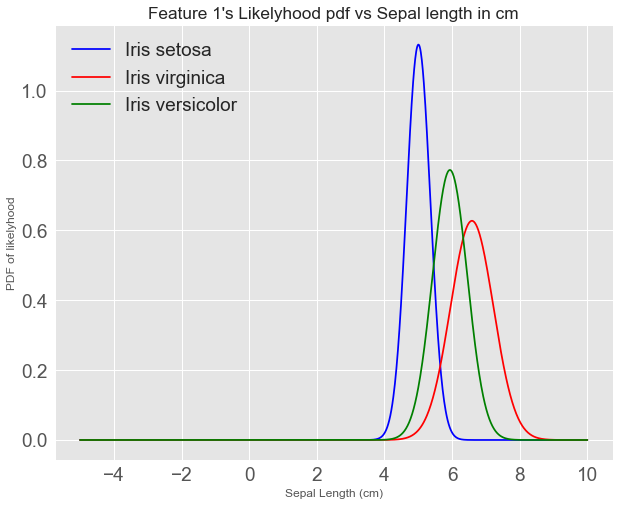

In [131]:
# I'll now plot the gaussian curves, 
# we can see the probability distribution of each feature given a particular class.

# Length in cm
x = np.linspace(-5, 10, 1000)

fig = plt.figure()
fig.set_size_inches(10, 8)

plt.title('Feature 1\'s Likelyhood pdf vs Sepal length in cm', size='xx-large')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('PDF of likelyhood')

# Note variance is the square of the standard deviation, here sd is the required input
plt.plot(x,mlab.normpdf(x, means[1][1], math.sqrt(variances[1][1]) ), c = 'b', label = 'Iris setosa')
plt.plot(x,mlab.normpdf(x, means[2][1], math.sqrt(variances[2][1]) ), c = 'r', label = 'Iris virginica')
plt.plot(x,mlab.normpdf(x, means[3][1], math.sqrt(variances[3][1]) ), c = 'g', label = 'Iris versicolor')

plt.legend(loc=2) # 2 => leftTop ; 1 => rightTop

plt.show()

Note that pdf can be greater than 1.0, the probability in this case is the **area under this graph**.

### Feature 2 :  Sepal Width 

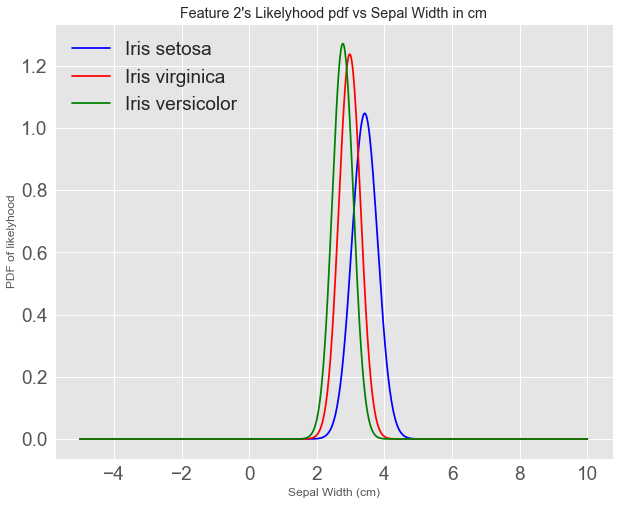

In [128]:
# Then Sepal Width (feature 2) for all 3 classes

fig = plt.figure()
fig.set_size_inches(10, 8)

plt.plot(x,mlab.normpdf(x, means[1][2], math.sqrt(variances[1][2]) ), c = 'b', label = 'Iris setosa')
plt.plot(x,mlab.normpdf(x, means[2][2], math.sqrt(variances[2][2]) ), c = 'r', label = 'Iris virginica')
plt.plot(x,mlab.normpdf(x, means[3][2], math.sqrt(variances[3][2]) ), c = 'g', label = 'Iris versicolor')

plt.legend(loc=2)

plt.xlabel('Sepal Width (cm)')
plt.ylabel('PDF of likelyhood')
plt.title('Feature 2\'s Likelyhood pdf vs Sepal Width in cm')
plt.show()

### Feature 3 :  Petal Length 

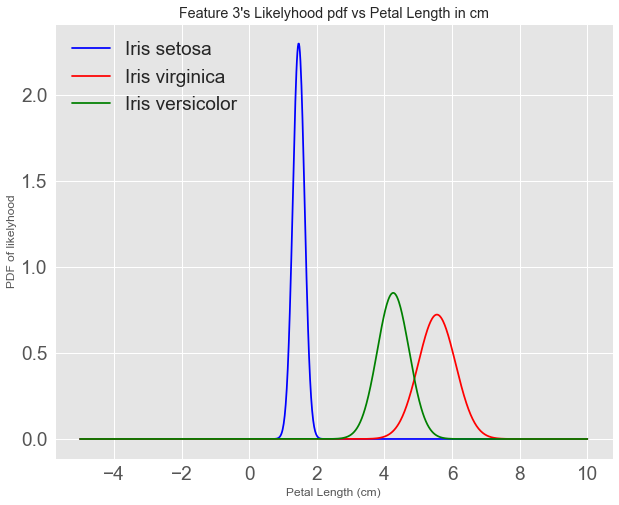

In [132]:
# Then Petal Length (feature 3) for all 3 classes

fig = plt.figure()
fig.set_size_inches(10, 8)

plt.plot(x,mlab.normpdf(x, means[1][3], math.sqrt(variances[1][3]) ), c = 'b', label = 'Iris setosa')
plt.plot(x,mlab.normpdf(x, means[2][3], math.sqrt(variances[2][3]) ), c = 'r', label = 'Iris virginica')
plt.plot(x,mlab.normpdf(x, means[3][3], math.sqrt(variances[3][3]) ), c = 'g', label = 'Iris versicolor')

plt.legend(loc=2)

plt.xlabel('Petal Length (cm)')
plt.ylabel('PDF of likelyhood')
plt.title('Feature 3\'s Likelyhood pdf vs Petal Length in cm')

plt.show()


### Feature 4 : Petal Width

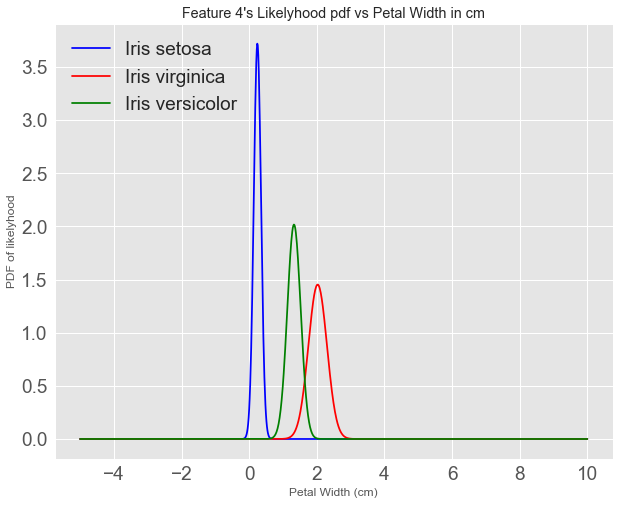

In [134]:
# Then Petal Width (feature 4) for all 3 classes

fig = plt.figure()
fig.set_size_inches(10, 8)

plt.plot(x,mlab.normpdf(x, means[1][4], math.sqrt(variances[1][4]) ), c = 'b', label = 'Iris setosa')
plt.plot(x,mlab.normpdf(x, means[2][4], math.sqrt(variances[2][4]) ), c = 'r', label = 'Iris virginica')
plt.plot(x,mlab.normpdf(x, means[3][4], math.sqrt(variances[3][4]) ), c = 'g', label = 'Iris versicolor')

plt.legend(loc=2)

plt.xlabel('Petal Width (cm)')
plt.ylabel('PDF of likelyhood')
plt.title('Feature 4\'s Likelyhood pdf vs Petal Width in cm')

plt.show()

## Posterior Probability

Now lets try to compute the posterior probability for the training set, then move on to the testing set

So we will get 3 posterier probabilities, one for each value of $i$

$$p(C_k \ | \; \mathbf {x}) \propto p(C_{k})\prod _{i=1}^{n}f(x_{i}\mid C_{k}) $$

We can calculate $p(C_k \ | \; \mathbf {x})$ by normalizing these 3 values, because each sample has to be in one of these 3 classes.

$$\sum_{k=1}^3 p(C_k \ | \; \mathbf {x}) = 1$$


In [104]:
# return f(x_i | C_k) 
# i.e. the probability density of getting "x" in feature i's prob distribution given class k
def pdfFeatureGivenClass(x,i,k):
    ourCalc = (1/math.sqrt(2*math.pi*variances[k][i]))*math.exp( (-(x-means[k][i])**2) / (2*variances[k][i]))
    scipyCalc = scipy.stats.norm( means[k][i], math.sqrt(variances[k][i]) ).pdf(x)
    
    # You might see around 10^(-16)
    #print("error in our calculation : "+str(scipyCalc-ourCalc))
    return(scipyCalc)


print(pdfFeatureGivenClass(0.1,4,1)) # Try different values

# Given a string - class name, return class no
def labelofClass(x):
    return {
        'Iris-setosa': 1,
        'Iris-virginica': 2,
        'Iris-versicolor': 3,
    }.get(x, -1)    # -1 is default if x not found

labelofClass('Iris-setosa') # Just testing it


1.50981390027


1

In [137]:
predictedProb = {}

# Posterior prob for Training set samples
for index, row in train.iterrows():
    print("\n\nFor the sample in the "+str(index)+"th row with id : "+str(row[0])+" the 4 features take the \nfollowing values in cm,\n")
    print("\nSepal Length : "+str(row[1])+
          "\nSepal Width : " +str(row[2])+
          "\nPetal Length : "+str(row[3])+
          "\nPetal Width : " +str(row[4]))
    
    assert (row[0] == index + 1) # Note id starts from 1 till 150 while index goes from 0 to 149
    
    actualClass = labelofClass(row[5])
    print("\nNote this sample is drawn from class no : "+str(actualClass))
    
    # p(C_k | \vec x) = predictedProb[indexOfX][k]
    preNormalized = {}
    
    # Iterate over 3 classes and 4 features
    for k in range(1,4):
        likelyhood = 1
        print("\n\n For class no "+str(k))
        for i in range(1,5):
            likelyhood = likelyhood * pdfFeatureGivenClass(row[i],i,k)
        print("\n \t the likelyhood is propotional to "+str(likelyhood))
        preNormalized[k] = classPriors[k]*likelyhood
        print("\n \t the posterior prob is propotional to "+str(preNormalized[k]))
        
    # To obtain actual posterior probabilities we normalize
    predictedProb[index] = normalize(np.array(list(preNormalized.values())).reshape(1,-1), norm='l1')
        
    print("\n Thus pre normalization the values were")
    print(preNormalized.values())
    
    print("\n After normalization we get the probabilities")
    print(predictedProb[index])
    

confArrayTrain = np.zeros((3,3))
# Classification using MAP rule
for index, row in train.iterrows():
    predictedClass = predictedProb[index].argmax() # 0 to 2 are the positions
    actualClass = labelofClass(row[5]) # 1 to 3 are the class labels
    confArrayTrain[actualClass-1][predictedClass] += 1
    
    print("Predicted : "+str(predictedClass)+" while true class : "+str(actualClass-1)+"\n\n")
    
print(confArrayTrain)
print("\n\nThe extent of rounding off errors are "+str(error))



For the sample in the 104th row with id : 105 the 4 features take the 
following values in cm,


Sepal Length : 6.5
Sepal Width : 3.0
Petal Length : 5.8
Petal Width : 2.2

Note this sample is drawn from class no : 2


 For class no 1

 	 the likelyhood is propotional to 9.05350791699e-212

 	 the posterior prob is propotional to 3.01783597233e-212


 For class no 2

 	 the likelyhood is propotional to 0.595019621514

 	 the posterior prob is propotional to 0.198339873838


 For class no 3

 	 the likelyhood is propotional to 1.88941667913e-07

 	 the posterior prob is propotional to 6.29805559709e-08

 Thus pre normalization the values were
dict_values([3.017835972331559e-212, 0.19833987383813526, 6.2980555970889229e-08])

 After normalization we get the probabilities
[[  1.52154731e-211   9.99999682e-001   3.17538449e-007]]


For the sample in the 23th row with id : 24 the 4 features take the 
following values in cm,


Sepal Length : 5.1
Sepal Width : 3.3
Petal Length : 1.7
Petal Wi

### Choosing a decision rule

The rule I used above is the maximum a posteriori or MAP decision rule.



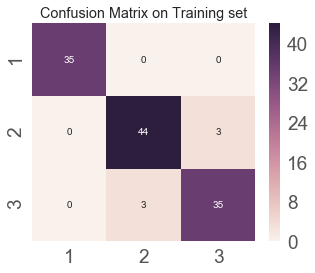

In [147]:
fig = plt.figure()
fig.set_size_inches(5, 4)

# Plotting the confusion matrix after MAP classification on training set
dfTraincm = pd.DataFrame(confArrayTrain, [1,2,3], [1,2,3])
plt.title('Confusion Matrix on Training set')
sn.heatmap(dfTraincm, annot=True)
plt.show()
# Horizontally - Actual Classes
# Vertically - Predicted Classes

In [144]:
# Classifying the testing set
posteriorProb = {}
errorRounding = 0

# Calculating posterior probability
for index, row in test.iterrows():
    print("\n\nFor the sample in the "+str(index)+"th row with id : "+str(row[0])+" the 4 features take the \nfollowing values in cm,\n")
    print("\nSepal Length : "+str(row[1])+
          "\nSepal Width : " +str(row[2])+
          "\nPetal Length : "+str(row[3])+
          "\nPetal Width : " +str(row[4]))
    
    assert (row[0] == index + 1) # Note id starts from 1 till 150 while index goes from 0 to 149
    
    actualClass = labelofClass(row[5])
    print("\nNote this sample is drawn from class no : "+str(actualClass))
    
    # p(C_k | \vec x) = predictedProb[indexOfX][k]
    preNormalized = {}
    
    # Iterate over 3 classes and 4 features
    for k in range(1,4):
        likelyhood = 1
        print("\n\n For class no "+str(k))
        for i in range(1,5):
            likelyhood = likelyhood * pdfFeatureGivenClass(row[i],i,k)
        print("\n \t the likelyhood is propotional to "+str(likelyhood))
        preNormalized[k] = classPriors[k]*likelyhood
        print("\n \t the posterior prob is propotional to "+str(preNormalized[k]))

    posteriorProb[index] = normalize(np.array(list(preNormalized.values())).reshape(1,-1), norm='l1')
        
    print("\n Thus pre normalization the values were")
    print(preNormalized.values())
    
    print("\n After normalization we get the probabilities")
    print(posteriorProb[index])
    
    errorRounding += abs(1 - posteriorProb[index].sum())
    
    print("\n --------------------------------------- \n")

confArrayTest = np.zeros((3,3))


# Classification using MAP rule
for index, row in test.iterrows():
    predictedClass = posteriorProb[index].argmax() # 0 to 2 are the positions
    actualClass = labelofClass(row[5]) # 1 to 3 are the class labels
    confArrayTest[actualClass-1][predictedClass] += 1
    
    print("Predicted : "+str(predictedClass)+" while true class : "+str(actualClass-1)+"\n\n")
    
print("\n\nThe extent of rounding off errors are "+str(error))

print(confArrayTest)



For the sample in the 67th row with id : 68 the 4 features take the 
following values in cm,


Sepal Length : 5.8
Sepal Width : 2.7
Petal Length : 4.1
Petal Width : 1.0

Note this sample is drawn from class no : 3


 For class no 1

 	 the likelyhood is propotional to 1.6511928304e-62

 	 the posterior prob is propotional to 5.50397610135e-63


 For class no 2

 	 the likelyhood is propotional to 7.71793448767e-06

 	 the posterior prob is propotional to 2.57264482922e-06


 For class no 3

 	 the likelyhood is propotional to 0.384482997041

 	 the posterior prob is propotional to 0.128160999014

 Thus pre normalization the values were
dict_values([5.5039761013482953e-63, 2.5726448292229023e-06, 0.12816099901369241])

 After normalization we get the probabilities
[[  4.29449338e-62   2.00731362e-05   9.99979927e-01]]

 --------------------------------------- 



For the sample in the 34th row with id : 35 the 4 features take the 
following values in cm,


Sepal Length : 4.9
Sepal Wid

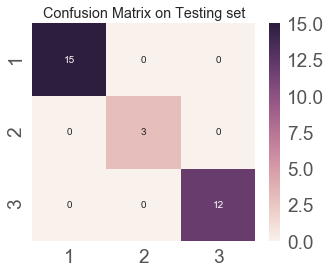

In [146]:
fig = plt.figure()
fig.set_size_inches(5,4)

# Testing Set confusion
dfTestcm = pd.DataFrame(confArrayTest, [1,2,3], [1,2,3])
plt.title('Confusion Matrix on Testing set')
sn.heatmap(dfTestcm, annot=True)
plt.show()


Other than the confusion matrix we can use [Micro and Macro averaged F1 measure](http://stats.stackexchange.com/a/44522/103024). 

For now lets try computing empirical error rate or misclassification rate,

Let $g$ be a classifier, and $x_i$ and $y_i$ be respectively an instance in your test dataset and its actual class. If $n$ such examples exist in the testing set then,

$$err(g)= \frac{1}{n} \sum_{i≤n}1_{g(x_i)≠y_i}$$

So this is the fraction of incorrectly classfied classes.

But this measure gives equal importance to all classes, but we should give more importance to underrepresented classes.

In [145]:
print(confArrayTest)
totalTest = test.count()[0]
emperror = 0

for i in range(3):
    for j in range(3):
        if(i == j):
            continue
        emperror = emperror + confArrayTest[i][j]
        
# Unweighted empirical error
print("\n \n The Misclassification rate is "+str(emperror/totalTest)+" \n")


print(train['Species'].value_counts())
print(test['Species'].value_counts())

[[ 15.   0.   0.]
 [  0.   3.   0.]
 [  0.   0.  12.]]

 
 The Misclassification rate is 0.0 

Iris-virginica     47
Iris-versicolor    38
Iris-setosa        35
Name: Species, dtype: int64
Iris-setosa        15
Iris-versicolor    12
Iris-virginica      3
Name: Species, dtype: int64


## Motivation for the independence assumption

Now note how we used the Naive independence assumption - the assumption that each feature is conditionally independent of each other given the class in order to avoid modelling likelyhood as a multivariate distribution, rather we could now model it as $n$ univariate distributions. 

We could argue that the [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is why we do this. [This](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/) is a great article for further reading.

Consider we form a histogram with only sepal length as a feature, we can discretize the values to say 0.1 cm widths. Then we would have maybe around 20 bins.

Once we add a new feature sepal width into the fray now we have $20\times20$ number of bins! See how sparse the available data becomes? We don't observe many important combinations. So with a fixed number of training samples, the predictive power reduces as the dimensionality increases.

So if we have $m$ bins and $n$ features, instead of $m^n$ bins we only have $m\times n$ bins if we go for $n$ univariate distributions.

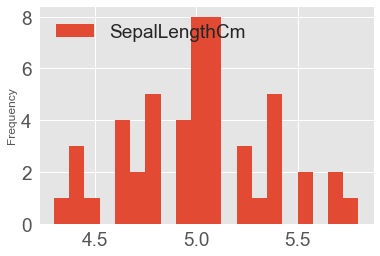

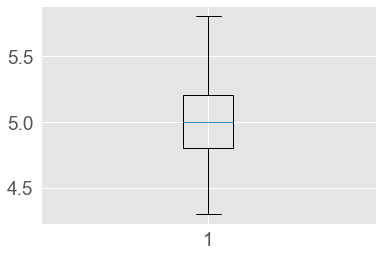

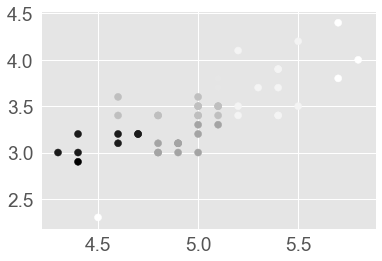

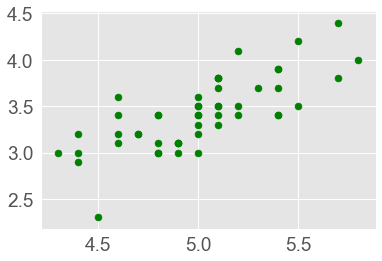

[  4.   5.  10.  10.   4.   1.   4.   4.  11.   5.   1.   4.   5.  10.   0.
   0.   1.   4.   0.   2.   1.   2.   4.   5.   4.   5.   4.   1.   1.  10.
   5.   1.   1.   1.   5.   5.   1.   5.  10.   4.   4.   0.  10.   4.   2.
   5.   2.  10.   1.   5.]


In [202]:
# take only one feature
oneFeatureSetosa = dfClasses["Iris-setosa"][['SepalLengthCm','Species']]
oneFeatureSetosa.plot.hist(bins=20)
plt.legend(loc=2)
plt.show()

plt.boxplot(oneFeatureSetosa['SepalLengthCm'].values)
plt.show()

twoFeatureSetosa = dfClasses["Iris-setosa"][['SepalLengthCm', 'SepalWidthCm', 'Species']]
x = twoFeatureSetosa['SepalLengthCm'].values
y = twoFeatureSetosa['SepalWidthCm'].values

lenEdges, widthEdges = np.linspace(2.5, 6.5, 10), np.linspace(2, 5, 10)
hist, lenEdges, widthEdges = np.histogram2d(x, y, (lenEdges, widthEdges))
xidx = np.clip(np.digitize(x, lenEdges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(y, widthEdges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
plt.scatter(x, y, c=c)
plt.show()
plt.scatter(x, y, c='g')
plt.show()

print(c)

But let us try using a bayesian classifier **without** the naive independence assumptions.

So in the orginal bayes equation,

$$ p(C_{k} \ | \ \mathbf {x}) = \frac {p(C_{k})\ p(\mathbf {x} \mid C_{k})}{p(\mathbf {x})} = \frac {p(\mathbf {x} , C_{k})}{p(\mathbf {x})}$$

Here we can model $p(\mathbf {x} \mid C_{k})$
   as a multivariate guassian distribution, so we have two parameters we need to compute the mean vector $\boldsymbol\mu_k$ and the covariance matrix ($ \boldsymbol\Sigma_k$) for each class. Note there are $n$ features.

$$p(\mathbf {x} \mid C_{k}) \sim\ \mathcal{N}(\boldsymbol\mu_k,\, \boldsymbol\Sigma_k)$$

The P.D.F of this distribution is,

$$\Large f(\mathbf {x} \; \ | \; \boldsymbol\mu_k , \boldsymbol\Sigma_k) = \frac{e^{\frac{ {(\mathbf {x}-\boldsymbol\mu_k)}^T {\boldsymbol\Sigma_k}^{\mathbf{-1}}(\mathbf {x} - \boldsymbol\mu_k)  }{2}}}{\sqrt{{2\pi}^n |\boldsymbol\Sigma_k|}}$$

![Multivariate](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/MultivariateNormal.png/300px-MultivariateNormal.png)

In [224]:
print(sum(train))
print("\n total no of instances in train = "+str(totalCount)+"\n\n")
x1 = sum(train)[1]/totalCount
x2 = sum(train)[2]/totalCount
x3 = sum(train)[3]/totalCount
x4 = sum(train)[4]/totalCount

# Sample mean 
xMean = np.array([x1,x2,x3,x4])

print(xMean)
print("\n")

# lets compute sample covariance matrix (unbiased)
q = np.zeros([4,4])

for i in range(totalCount):
    temp = np.array([train.iloc[i][1], train.iloc[i][2], train.iloc[i][3], train.iloc[i][4]])
    q = q + np.matmul((temp - xMean),np.transpose(temp - xMean))
    
q = q/(totalCount-1)

print(q)



Id                                                            9666
SepalLengthCm                                                  709
SepalWidthCm                                                 363.1
PetalLengthCm                                                474.4
PetalWidthCm                                                 154.6
Species          Iris-virginicaIris-setosaIris-setosaIris-versi...
dtype: object

 total no of instances in train = 120


[ 5.90833333  3.02583333  3.95333333  1.28833333]


[[ 4.48490686  4.48490686  4.48490686  4.48490686]
 [ 4.48490686  4.48490686  4.48490686  4.48490686]
 [ 4.48490686  4.48490686  4.48490686  4.48490686]
 [ 4.48490686  4.48490686  4.48490686  4.48490686]]


In [ ]:
# return f(\vec x) for MULTIVARIATE GUASSIAN note no given class
def pdfFeatureMultiVariate(x,k):
    return(None)
